In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter as gf
from sklearn import model_selection, datasets, metrics, tree

In [2]:
class DecisionTree():
    def __init__(self, maxdepth=6, maxelemsleaf=1):
        self.maxdepth = maxdepth
        self.maxelemsleaf = maxelemsleaf
        self.tree = []
    
    def fit(self, xdf, y=None, curr_depth=0, node=None, isBegin=True):

        if xdf.shape[0] == 0:
            print('Error: xdf.shape[0] == 0')
            return -1
        if isBegin:
            node = self.tree
            xdf = pd.DataFrame(xdf).copy()
            xdf['target'] = y
        self.dimx = xdf.shape[-1] - 1
        N = xdf.shape[0]
        if N <= self.maxelemsleaf:
            node.append(np.mean(xdf.target.values))
            return 0
        
        if curr_depth < self.maxdepth or self.maxdepth == -1:
            err = -1
            porogs = gf(np.sort((xdf.iloc[:, :-1]).values, axis=0), np.mean, size=(3, 1)).T
            im, pm = 0, (porogs[0, 0] if porogs[0].size > 0 else 0)
            # im - индекс, pm - порог
            # находим разбиение с минимальной ошибкой stdn
            for i in range(self.dimx):
                for p in np.unique(porogs[i]):
                    # вычисляем ошибку 
                    L = xdf[xdf[i] <= p]
                    R = xdf[xdf[i] > p]
                    tl = L.iloc[:, -1:].values
                    tr = R.iloc[:, -1:].values
                    stdn = tl.size*np.std(tl) + tr.size*np.std(tr)
                    
                    if err == -1:
                        err = stdn
                        im, pm = i, p
                    if err > stdn:
                        err = stdn
                        im, pm = i, p           
            L = xdf[xdf[im] <= pm]
            R = xdf[xdf[im] > pm]
            if L.size == 0 or R.size == 0:
                node.append(np.mean(xdf.target.values))
            else:
                node += [im, pm, [], []]
                child_node_l = node[2]
                child_node_r = node[3]
                # реккурсивный вызов fit для ветвей дерева
                self.fit(L, curr_depth=curr_depth + 1, node=child_node_l, isBegin=False)
                self.fit(R, curr_depth=curr_depth + 1, node=child_node_r, isBegin=False)
        elif curr_depth == self.maxdepth:
            node.append(np.mean(xdf.target.values))
            return 1
    
    def predict(self, x, isBegin=True):
        if isBegin:
            nd = self.tree
        def f(x, node=nd):
            while len(node) == 4:
                node = node[2] if x[node[0]] <= node[1] else node[3]
            return node[0]
        y = np.apply_along_axis(f, -1, x)
        return y
    
    

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()
boston_data = pd.DataFrame(boston.data)
boston_data['target'] = boston.target
boston_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Разделим датасет на тренировку и тест

In [4]:
X, y = boston_data.iloc[:, :-1], boston_data.iloc[:, -1]
train_len = int(0.75 * len(X))
X_train, X_test, y_train, y_test = X.iloc[:train_len], X.iloc[train_len:], y.iloc[:train_len], y.iloc[train_len:]
# print(list(map(lambda x: x.shape, (X_train, X_test, y_train, y_test))))

С ограничением глубины дерева

In [5]:
model = DecisionTree(maxdepth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('maxdepth = 3, Error =', metrics.mean_squared_error(y_test, y_pred))

/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


maxdepth = 3, Error = 52.4316621478


Без ограничения глубины. Возникает переобучение.

In [6]:
model = DecisionTree()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Error =', metrics.mean_squared_error(y_test, y_pred))

/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error = 107.703720618


Сравнение с решающим деревом из библиотеки sklearn

In [7]:
model = tree.DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('max_depth = 3, Error =', metrics.mean_squared_error(y_test, y_pred))

max_depth = 3, Error = 31.9963723586


Проверка адекватности работы алгоритма на примере регрессии функции одного переменного

/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


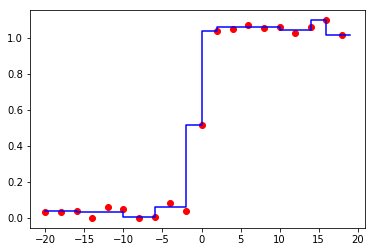

In [8]:
args = (-20, 20)
x_tr = np.arange(*args, 2)
y_tr = 1/(1 + np.exp(-10*x_tr)) + 0.1*np.random.rand(x_tr.size)
plt.plot(x_tr, y_tr, 'ro')
DT = DecisionTree(maxdepth=5, maxelemsleaf=3)
DT.fit(x_tr.reshape((len(x_tr), 1)), y_tr)
x_test = np.arange(*args)
xt = x_test.reshape((len(x_test), 1))
y_pr = DT.predict(xt)
plt.step(x_test, y_pr, 'b')
plt.show()


Возьмем рандомизированное разбиение на обучение и тест.

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Снова проверим результат работы алгоритмов с ограничением и без

In [10]:
model = DecisionTree(maxdepth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('maxdepth = 3, Error =', metrics.mean_squared_error(y_test, y_pred))

/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


maxdepth = 3, Error = 19.7202996317


In [11]:
model = DecisionTree()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Error =', metrics.mean_squared_error(y_test, y_pred))

/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/daniel/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error = 14.058014477


In [12]:
model = tree.DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('max_depth = 3, Error =', metrics.mean_squared_error(y_test, y_pred))

max_depth = 3, Error = 39.4665486481


Вывод: рандомизация помогает бороться с переобучением